# Initilizing

In [103]:
import numpy as np
import pandas as pd
import re, warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import gensim


# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim as gensimvis
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline
import seaborn as sns
from collections import Counter

import pickle


from wordcloud import WordCloud
import matplotlib.colors as mcolors


pd.set_option("max_rows", None)
pd.set_option('display.width', None)
pd.set_option('max_columns', None)
pd.set_option('max_colwidth', 200)

# Functions

In [104]:
def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


def getTopReviewsForEachTopic(df_topic_sents_keywords):

    # Group top 5 sentences under each topic
    sent_topics_sorted = pd.DataFrame()
    df_append = pd.DataFrame()

    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
#         print(f'i = {i}')
#         print(grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5))


        df_topic_epitome_reviews = pd.concat([grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                                axis=0, ignore_index=True)

    #     testAppend =  grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)

        df_append = df_append.append(df_topic_epitome_reviews, ignore_index=True)

        #test = df_topic_sents_keywords1.groupby(['Dominant_Topic'], as_index=False)[0].count()

    #     print(type(df_topic_epitome_reviews))
    #     sent_topics_sorted

    # Reset Index    
    df_append.reset_index(drop=True, inplace=True)

    # Format
    df_append.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
    return df_append


def createwordcloud(ldamodel, numberofTopics):
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = ldamodel.show_topics(formatted=False)


    if numberofTopics <=4:
        fig, axes = plt.subplots(1, 4, figsize=(15,10), sharex=True, sharey=True)
#     elif numberofTopics<=6:
#         fig, axes = plt.subplots(2, 3, figsize=(15,20), sharex=True, sharey=True)
#     elif numberofTopics<=9:
#         fig, axes = plt.subplots(3, 3, figsize=(15,30), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        if i < numberofTopics:
            #print("here")
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=300)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
            plt.gca().axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.axis('off')
            plt.margins(x=0, y=0)
        else:
            k = 1
   
    plt.tight_layout()
    plt.show()
    
def showTopwordsPertopicInGraph (ldamodel):
    from collections import Counter
    topics = ldamodel.show_topics(formatted=False)
    data_flat = [w for w_list in doc_clean_tokenized_Lem for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
    
    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 2500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
                label.set_fontname('Arial')
                label.set_fontsize(15)

        ax_twin.set_yticklabels([0, .02,.04,.06,.08], fontsize=15)

    fig.tight_layout(w_pad=2)    
    fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
    plt.show()    
    return df

def gettopicwordsIntoDataframe(optimal_model):
    df_all = pd.DataFrame()
    for topic_idx, topic in enumerate(optimal_model.show_topics(formatted=False)):
        df = pd.DataFrame(topic[1], columns =['word', 'Percent'])
        df['Topic'] = topic_idx
        df_all = df_all.append(df)

    df_all['Percent'] = df_all['Percent'].astype(float).round(2)
    return df_all

def createheatmapofTopwords(df_all):

    fig, ax = plt.subplots(figsize=(17,100))
    sns.heatmap(pd.crosstab([df_all.Topic], [df_all.word]),
                cmap="YlGnBu", annot=True, cbar=False, xticklabels=True, yticklabels=True,
                vmax=1.5, vmin=0, square=True, 
                annot_kws={"fontsize":20}
               )
#     sns.set(font_scale=3)
    plt.show();
    

# Loading The Data

In [105]:
file = open("df_ModelInfo.pickle", "rb")
df_ModelInfo = pickle.load(file)
file.close

file = open("df_ModelInfo_P.pickle", "rb")
df_ModelInfo_P = pickle.load(file)
file.close

file = open("df_ModelInfo_N.pickle", "rb")
df_ModelInfo_N = pickle.load(file)
file.close


with open('df_reviews.pickle', 'rb') as f:
    df_reviews = pickle.load(f)
      
with open('df_reviews_P.pickle', 'rb') as f:
    df_reviews_P = pickle.load(f)

with open('df_reviews_N.pickle', 'rb') as f:
    df_reviews_N = pickle.load(f)


# with open('doc_term_matrix.pickle', 'rb') as f:
#     doc_term_matrix = pickle.load(f)

with open('doc_term_matrix_tfidf.pickle', 'rb') as f:
    doc_term_matrix = pickle.load(f)

with open('doc_term_matrix_tfidf_P.pickle', 'rb') as f:
    doc_term_matrix_P = pickle.load(f)

with open('doc_term_matrix_tfidf_N.pickle', 'rb') as f:
    doc_term_matrix_N = pickle.load(f)

    
data = df_reviews.Text.to_list()
data_P = df_reviews_P.Text.to_list()
data_N = df_reviews_N.Text.to_list()
# MalletFunctModel = optimal_modelHDP 

doc_clean_tokenized_Lem = [review.split() for review in df_reviews["TextClean4"]]
doc_clean_tokenized_Lem_P = [review.split() for review in df_reviews_P["TextClean4"]]
doc_clean_tokenized_Lem_N = [review.split() for review in df_reviews_N["TextClean4"]]


doc_tokenized = [review.split() for review in df_reviews["Text"]]

corpus_dictionary = Dictionary(doc_clean_tokenized_Lem)
corpus_dictionary_P = Dictionary(doc_clean_tokenized_Lem_P)
corpus_dictionary_N = Dictionary(doc_clean_tokenized_Lem_N)

In [106]:
df_ModelInfo

,ModelName,Model,NumberOfTopics,Coherence
0,ldatfidf,"LdaModel(num_terms=366, num_topics=4, decay=0.02, chunksize=50)",4,0.459288
1,ldatfidf,"LdaModel(num_terms=366, num_topics=5, decay=0.02, chunksize=50)",5,0.524011
2,ldatfidf,"LdaModel(num_terms=366, num_topics=6, decay=0.02, chunksize=50)",6,0.476567
3,ldatfidf,"LdaModel(num_terms=366, num_topics=7, decay=0.02, chunksize=50)",7,0.457514


In [107]:
df_ModelInfo_P

,ModelName,Model,NumberOfTopics,Coherence
0,ldatfidf,"LdaModel(num_terms=366, num_topics=4, decay=0.02, chunksize=50)",4,0.497222
1,ldatfidf,"LdaModel(num_terms=366, num_topics=5, decay=0.02, chunksize=50)",5,0.497486
2,ldatfidf,"LdaModel(num_terms=366, num_topics=6, decay=0.02, chunksize=50)",6,0.557967
3,ldatfidf,"LdaModel(num_terms=366, num_topics=7, decay=0.02, chunksize=50)",7,0.546413


In [108]:
df_ModelInfo_N

,ModelName,Model,NumberOfTopics,Coherence
0,ldatfidf,"LdaModel(num_terms=292, num_topics=2, decay=0.02, chunksize=50)",2,0.603598
1,ldatfidf,"LdaModel(num_terms=292, num_topics=3, decay=0.02, chunksize=50)",3,0.689918


In [109]:
# Select the model and print the topics
# HDPnumberOfTopics = 5
numberOfTopics = 4
optimal_model = df_ModelInfo[(df_ModelInfo["ModelName"] == "ldatfidf") & (df_ModelInfo["NumberOfTopics"]==numberOfTopics)]["Model"].values[0]

numberOfTopics_P = 4
optimal_model_P = df_ModelInfo_P[(df_ModelInfo_P["ModelName"] == "ldatfidf") & (df_ModelInfo_P["NumberOfTopics"]==numberOfTopics_P)]["Model"].values[0]

numberOfTopics_N = 2
optimal_model_N = df_ModelInfo_N[(df_ModelInfo_N["ModelName"] == "ldatfidf") & (df_ModelInfo_N["NumberOfTopics"]==numberOfTopics_N)]["Model"].values[0]


In [120]:
len(df_reviews_N)

134

# Visualizing Results

## All Reviews

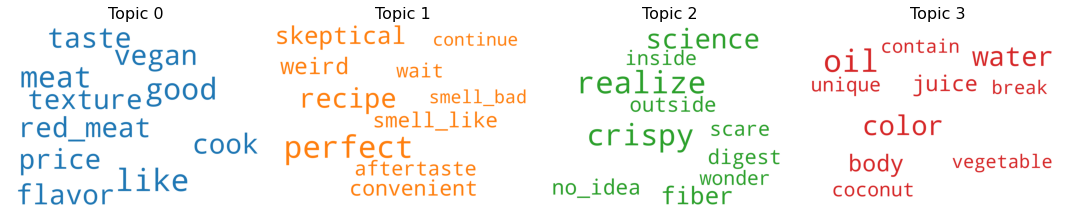

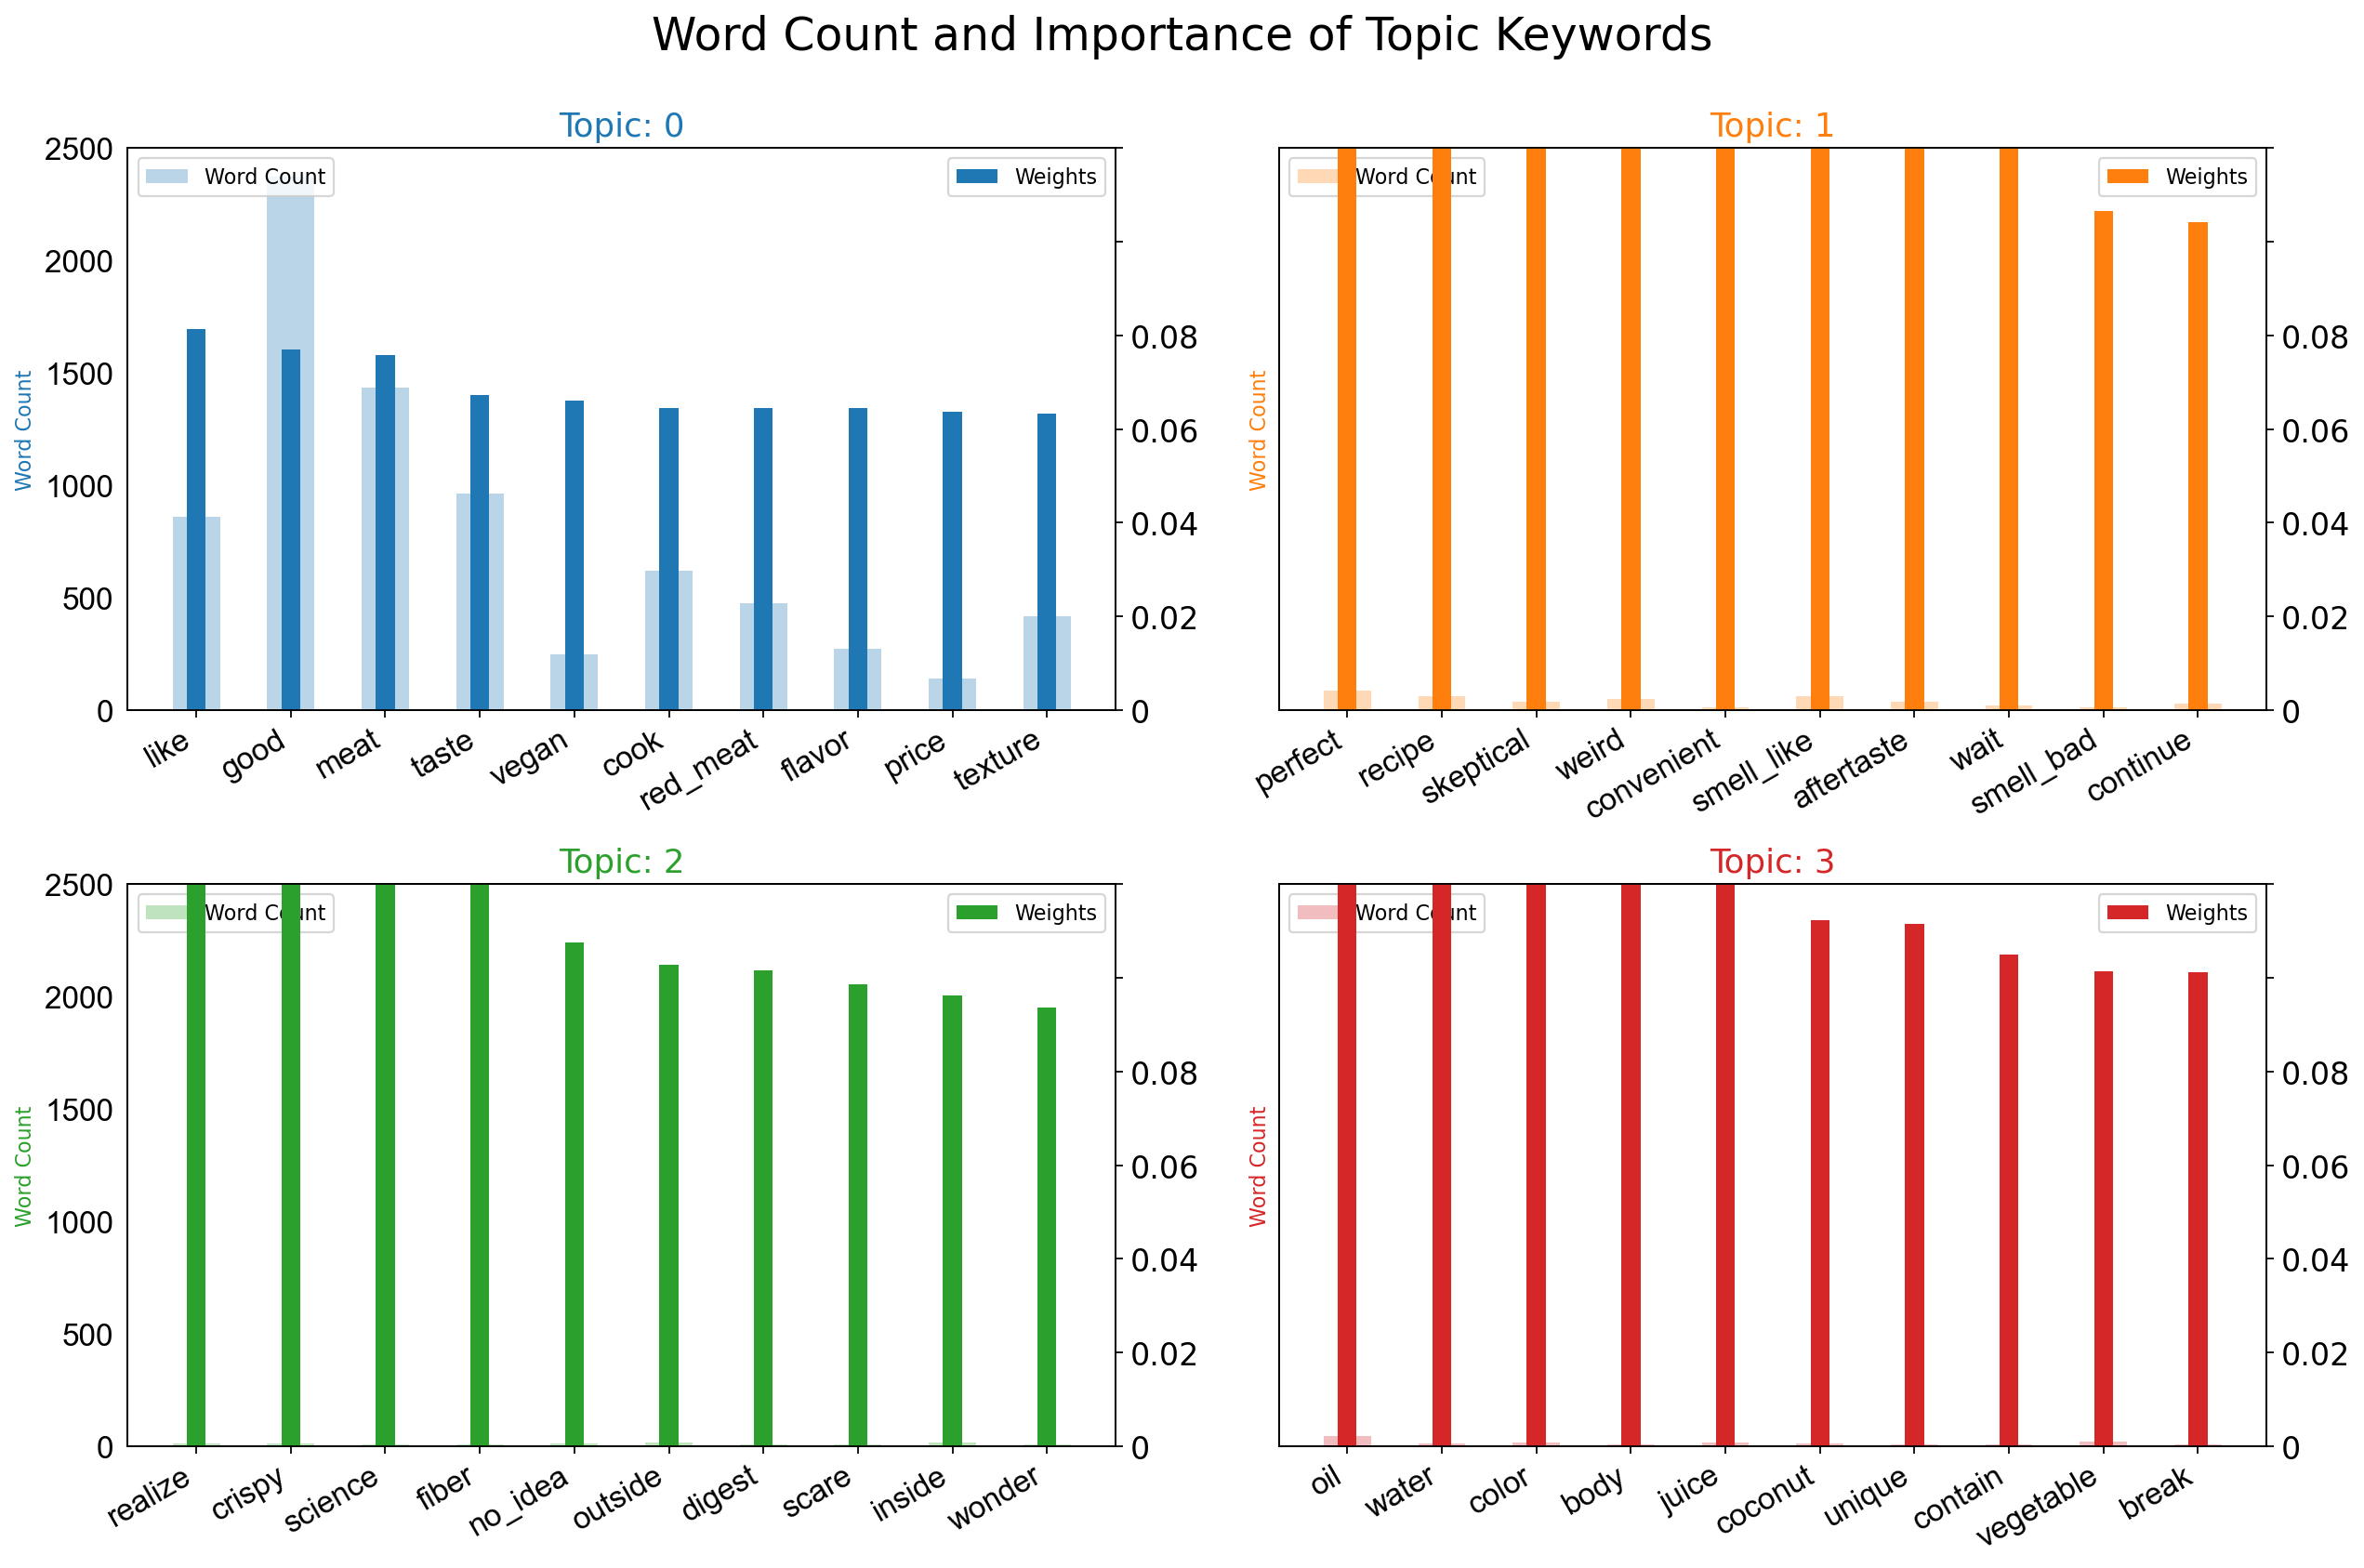

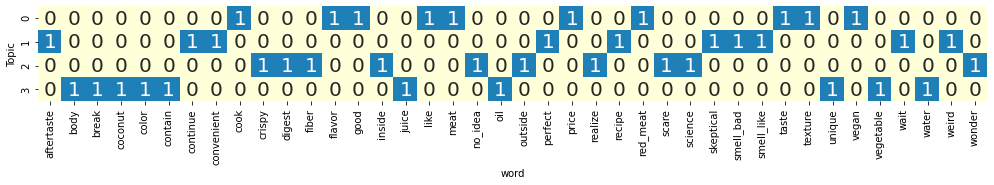

In [110]:
df_topic_sents_keywords = format_topics_sentences(optimal_model, doc_term_matrix, data)


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# df_dominant_topic.to_excel("df_TopReviewPerTopic.xlsx")

df_TopReviewPerTopic = getTopReviewsForEachTopic(df_topic_sents_keywords)

df_reviewsInitialText = df_reviews[['Text','TextClean', 'TextClean4']]
df_TopReviewPerTopic.merge(df_reviewsInitialText, how='left', on='Text')
df_TopReviewPerTopic.head()

df_TopReviewPerTopic.to_excel("df_TopReviewPerTopic.xlsx")

createwordcloud(optimal_model, numberOfTopics)
df_wordImp = showTopwordsPertopicInGraph(optimal_model)
createheatmapofTopwords(gettopicwordsIntoDataframe(optimal_model))

In [111]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()
df_append = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
#     print(f'i = {i}')
#     print(grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5))
    
    
    df_topic_epitome_reviews = pd.concat([grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0, ignore_index=True)
    
#     testAppend =  grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)
    
    df_append = df_append.append(df_topic_epitome_reviews, ignore_index=True)
 
    #test = df_topic_sents_keywords1.groupby(['Dominant_Topic'], as_index=False)[0].count()
    
#     print(type(df_topic_epitome_reviews))
#     sent_topics_sorted

# Reset Index    
df_append.reset_index(drop=True, inplace=True)

# Format
df_append.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
df_append

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9030,"like, good, meat, taste, vegan, cook, red_meat, flavor, price, texture","Morning Star tends to be an inexpensive brand I pickup often for vegan chicken strips and beef crumbles, so when Influenster sent me a cash back offer to try the new ""Incogmeato"" vegan burger patt..."
1,0.0,0.8983,"like, good, meat, taste, vegan, cook, red_meat, flavor, price, texture",When I first got this I was quite hyped seeing the reviews and the packaging thinking they may have finally gotten a beef clone. After mildly cooking it I was disappointed to taste the same taste ...
2,0.0,0.8965,"like, good, meat, taste, vegan, cook, red_meat, flavor, price, texture","Full disclosure: I'm not a vegan or vegetarian. in fact, I absolutely love meat and especially a nice juicy rare burger. With that in mind, my experience with fake meat products is limited. This i..."
3,0.0,0.8955,"like, good, meat, taste, vegan, cook, red_meat, flavor, price, texture","I was not expecting much from this product as I am a meat eater, but was very curious. I have to say it was better than I expected it to be. It did need lot of ""doctoring up"" with seasonings to ge..."
4,0.0,0.8923,"like, good, meat, taste, vegan, cook, red_meat, flavor, price, texture","I was eating a vegetarian diet for many years. Then, I married a full on carnivore who has to have meat with every meal. Slowly, he turned me back to a weekly meat eater. It was just too hard to f..."
5,1.0,0.6695,"perfect, recipe, skeptical, weird, convenient, smell_like, aftertaste, wait, smell_bad, continue",They taste much better then other plant bass products I've used In the past. No weird texture or strange after taste
6,1.0,0.6695,"perfect, recipe, skeptical, weird, convenient, smell_like, aftertaste, wait, smell_bad, continue",They taste much better then other plant bass products I've used In the past. No weird texture or strange after taste
7,1.0,0.6031,"perfect, recipe, skeptical, weird, convenient, smell_like, aftertaste, wait, smell_bad, continue",The product works perfectly in recipes using ground meat. Even my omnivore husband will eat it!
8,1.0,0.5574,"perfect, recipe, skeptical, weird, convenient, smell_like, aftertaste, wait, smell_bad, continue",I worked as a sales unit controller for Swifts in 72 became a vegetarian grew alfalfa sprouts for 18 years made veggie burgers no backing now make doggie treats I love the way your burgers taste !...
9,1.0,0.5543,"perfect, recipe, skeptical, weird, convenient, smell_like, aftertaste, wait, smell_bad, continue","Impossible burgers are delicious! Imagine having a great hamburger alternative experience without antibiotics, hormones and pesticides!"


In [112]:
# get dataframe of key topics and probs
df_Topic_KeyWords = pd.DataFrame()

for i in range(len(optimal_model.show_topics(formatted=False))):
    topic = optimal_model.show_topics(formatted=False)[i][0]
#     print(topic)
    setofKeyWordsAndValues = optimal_model.show_topics(formatted=False)[i][1]
    df = pd.DataFrame(setofKeyWordsAndValues, columns = ["word", "prob"])
    df['topic'] = i
    df_Topic_KeyWords = df_Topic_KeyWords.append(df, ignore_index = True)

## Positive Reviews

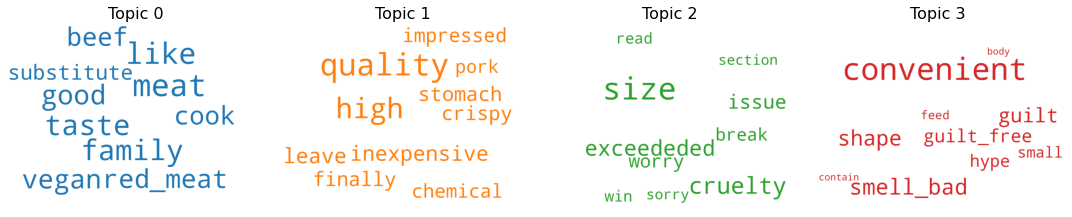

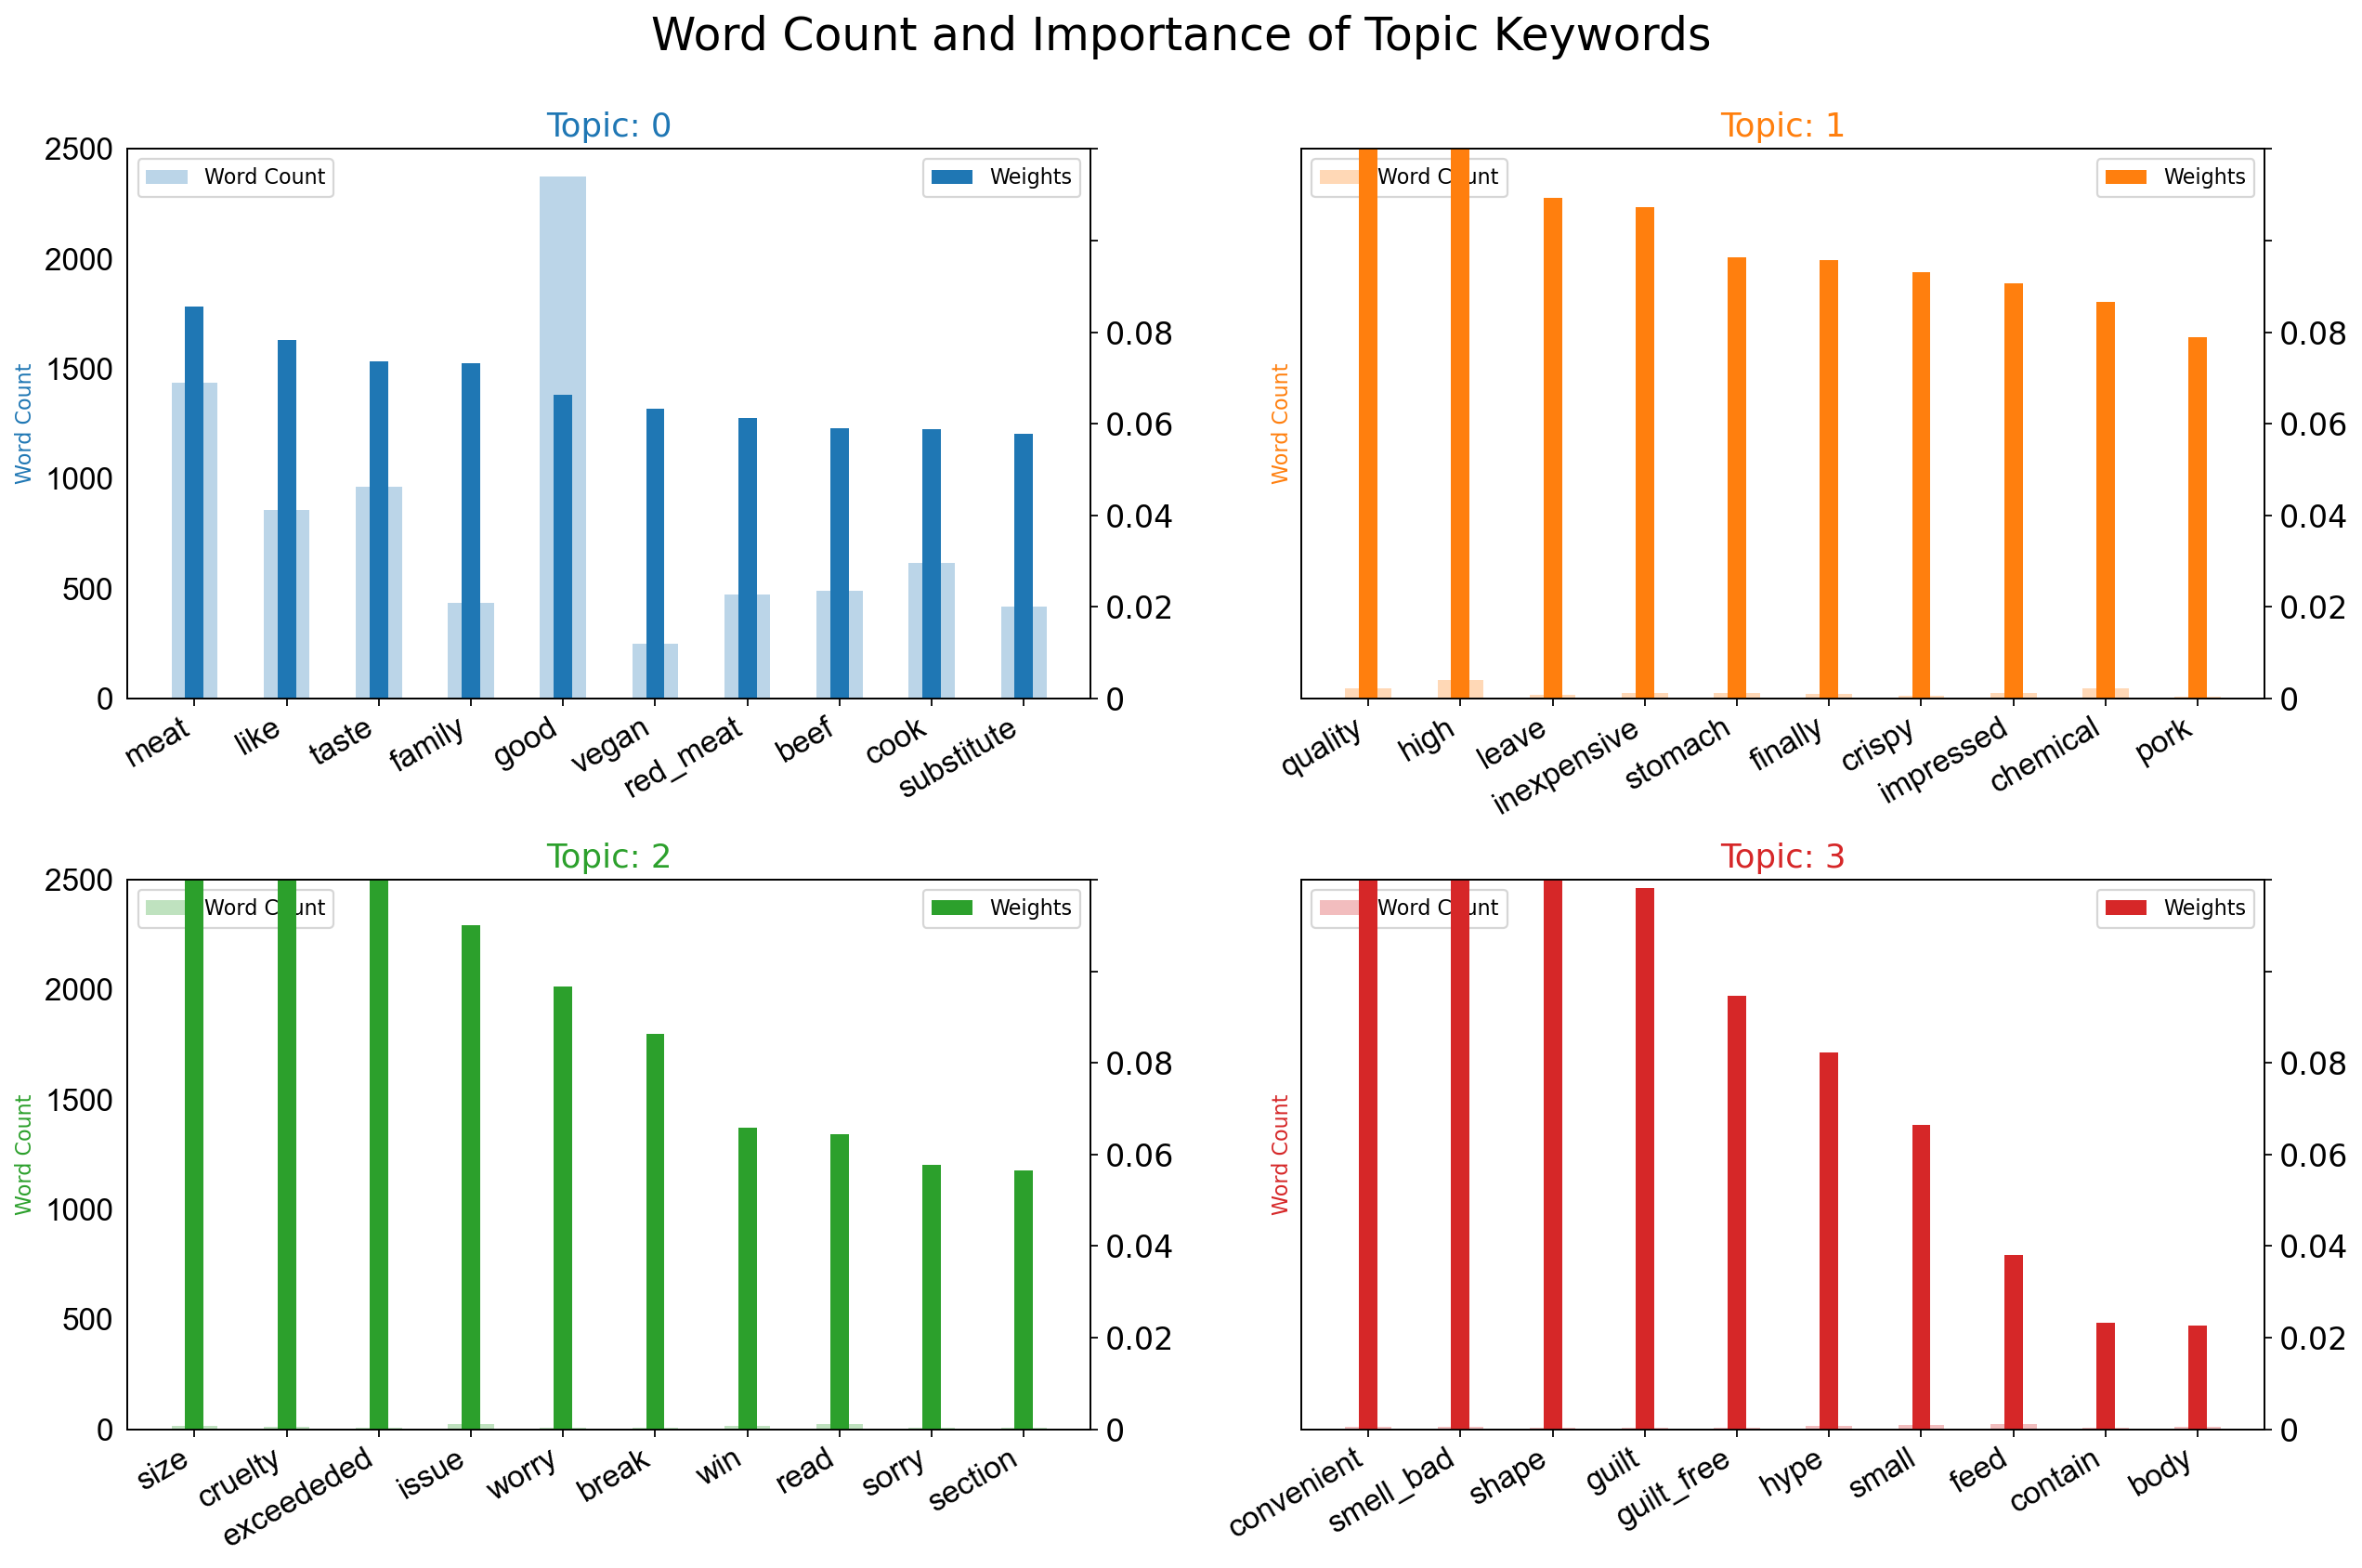

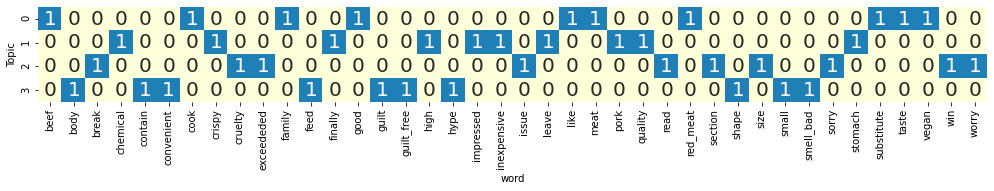

In [113]:
df_topic_sents_keywords = format_topics_sentences(optimal_model_P, doc_term_matrix_P, data_P)


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# df_dominant_topic.to_excel("df_TopReviewPerTopic.xlsx")

df_TopReviewPerTopic = getTopReviewsForEachTopic(df_topic_sents_keywords)

df_reviewsInitialText = df_reviews[['Text','TextClean', 'TextClean4']]
df_TopReviewPerTopic.merge(df_reviewsInitialText, how='left', on='Text')
df_TopReviewPerTopic.head()

df_TopReviewPerTopic.to_excel("df_TopReviewPerTopic_P.xlsx")

createwordcloud(optimal_model_P, numberOfTopics_P)
df_wordImp = showTopwordsPertopicInGraph(optimal_model_P)
createheatmapofTopwords(gettopicwordsIntoDataframe(optimal_model_P))

In [114]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()
df_append_P = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
#     print(f'i = {i}')
#     print(grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5))
    
    
    df_topic_epitome_reviews = pd.concat([grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0, ignore_index=True)
    
#     testAppend =  grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)
    
    df_append_P = df_append_P.append(df_topic_epitome_reviews, ignore_index=True)
 
    #test = df_topic_sents_keywords1.groupby(['Dominant_Topic'], as_index=False)[0].count()
    
#     print(type(df_topic_epitome_reviews))
#     sent_topics_sorted

# Reset Index    
df_append_P.reset_index(drop=True, inplace=True)

# Format
df_append_P.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
df_append_P

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9011,"meat, like, taste, family, good, vegan, red_meat, beef, cook, substitute",My husband was diagnosed with Prostate cancer and after doing research he decided to become Vegan. This is a great substitute for beef. He loves it and uses it in everything where he used to use g...
1,0.0,0.8997,"meat, like, taste, family, good, vegan, red_meat, beef, cook, substitute","We put them in the freezer and took them out to grill- 'Cooked them slowly, and they held together well on the grill - and as the sizzling started and the smoke rose from the fire they smelled mor..."
2,0.0,0.8991,"meat, like, taste, family, good, vegan, red_meat, beef, cook, substitute","I've been a vegetarian for 33 years. My 10yo daughter has never eaten meat. My husband on the other hand can't get enough meat on his plate. One day, I decided to make us all burgers. My husband h..."
3,0.0,0.8970,"meat, like, taste, family, good, vegan, red_meat, beef, cook, substitute","I've tried a bunch of fake meat products by other brands (Impossible, Beyond, Gardein, etc.) and this by far is my favorite so far. I'm not a vegan or vegetarian but I would like to start lessenin..."
4,0.0,0.8922,"meat, like, taste, family, good, vegan, red_meat, beef, cook, substitute","My husband and I are now vegans, and since I love to cook we've been trying multitudes of recipes, including ones using vegan ""beef"" products. We give each product a few tries before making a fina..."
5,1.0,0.7143,"quality, high, leave, inexpensive, stomach, finally, crispy, impressed, chemical, pork","Extraordinary product. Exquisite taste. Kind, considerate, and responsive customer service. It is rare to find such a flavorful, high-quality, all-vegetable product. And this is a company deeply d..."
6,1.0,0.7143,"quality, high, leave, inexpensive, stomach, finally, crispy, impressed, chemical, pork","Extraordinary product. Exquisite taste. Kind, considerate, and responsive customer service. It is rare to find such a flavorful, high-quality, all-vegetable product. And this is a company deeply d..."
7,1.0,0.6448,"quality, high, leave, inexpensive, stomach, finally, crispy, impressed, chemical, pork",I got a sample of the Impossible Burger Patties Made from Plants and I'm reviewing it as follows. I loved this burger it's so much better quality and tastes so much better than any other plant bas...
8,1.0,0.6288,"quality, high, leave, inexpensive, stomach, finally, crispy, impressed, chemical, pork",I love how sustainable the impossible burger was. It felt super light on my stomach and it was delicious!
9,1.0,0.5752,"quality, high, leave, inexpensive, stomach, finally, crispy, impressed, chemical, pork","Impossible burgers are delicious! Imagine having a great hamburger alternative experience without antibiotics, hormones and pesticides!"


In [115]:
# get dataframe of key topics and probs
df_Topic_KeyWords = pd.DataFrame()

for i in range(len(optimal_model.show_topics(formatted=False))):
    topic = optimal_model.show_topics(formatted=False)[i][0]
#     print(topic)
    setofKeyWordsAndValues = optimal_model.show_topics(formatted=False)[i][1]
    df = pd.DataFrame(setofKeyWordsAndValues, columns = ["word", "prob"])
    df['topic'] = i
    df_Topic_KeyWords = df_Topic_KeyWords.append(df, ignore_index = True)

## Negative Reviews

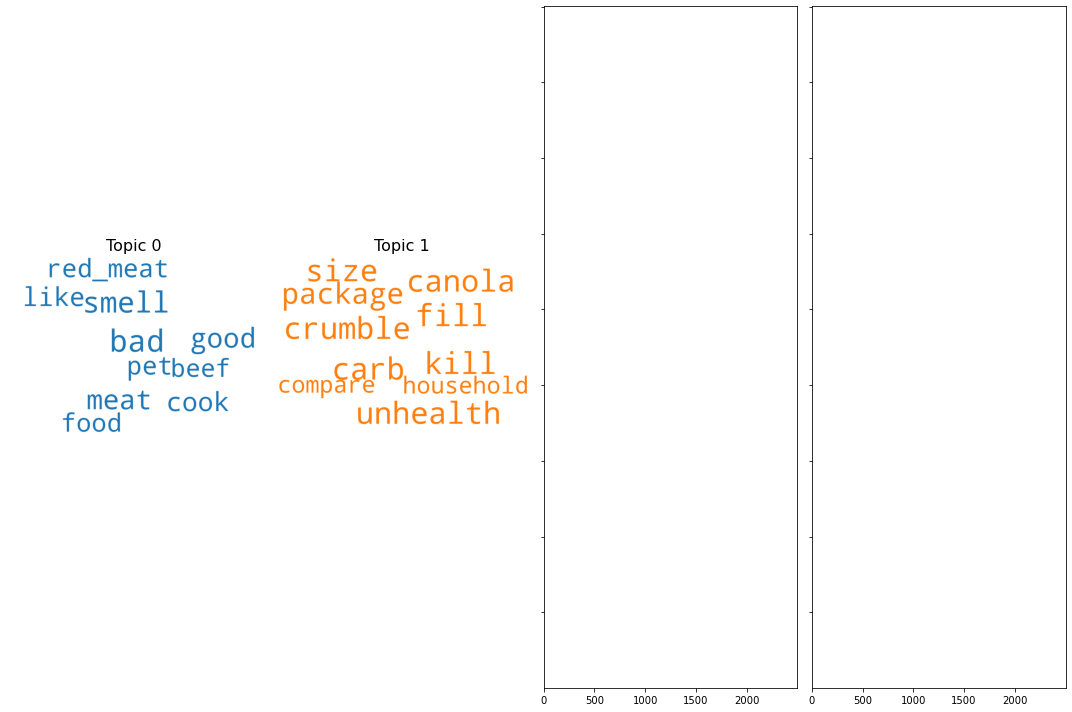

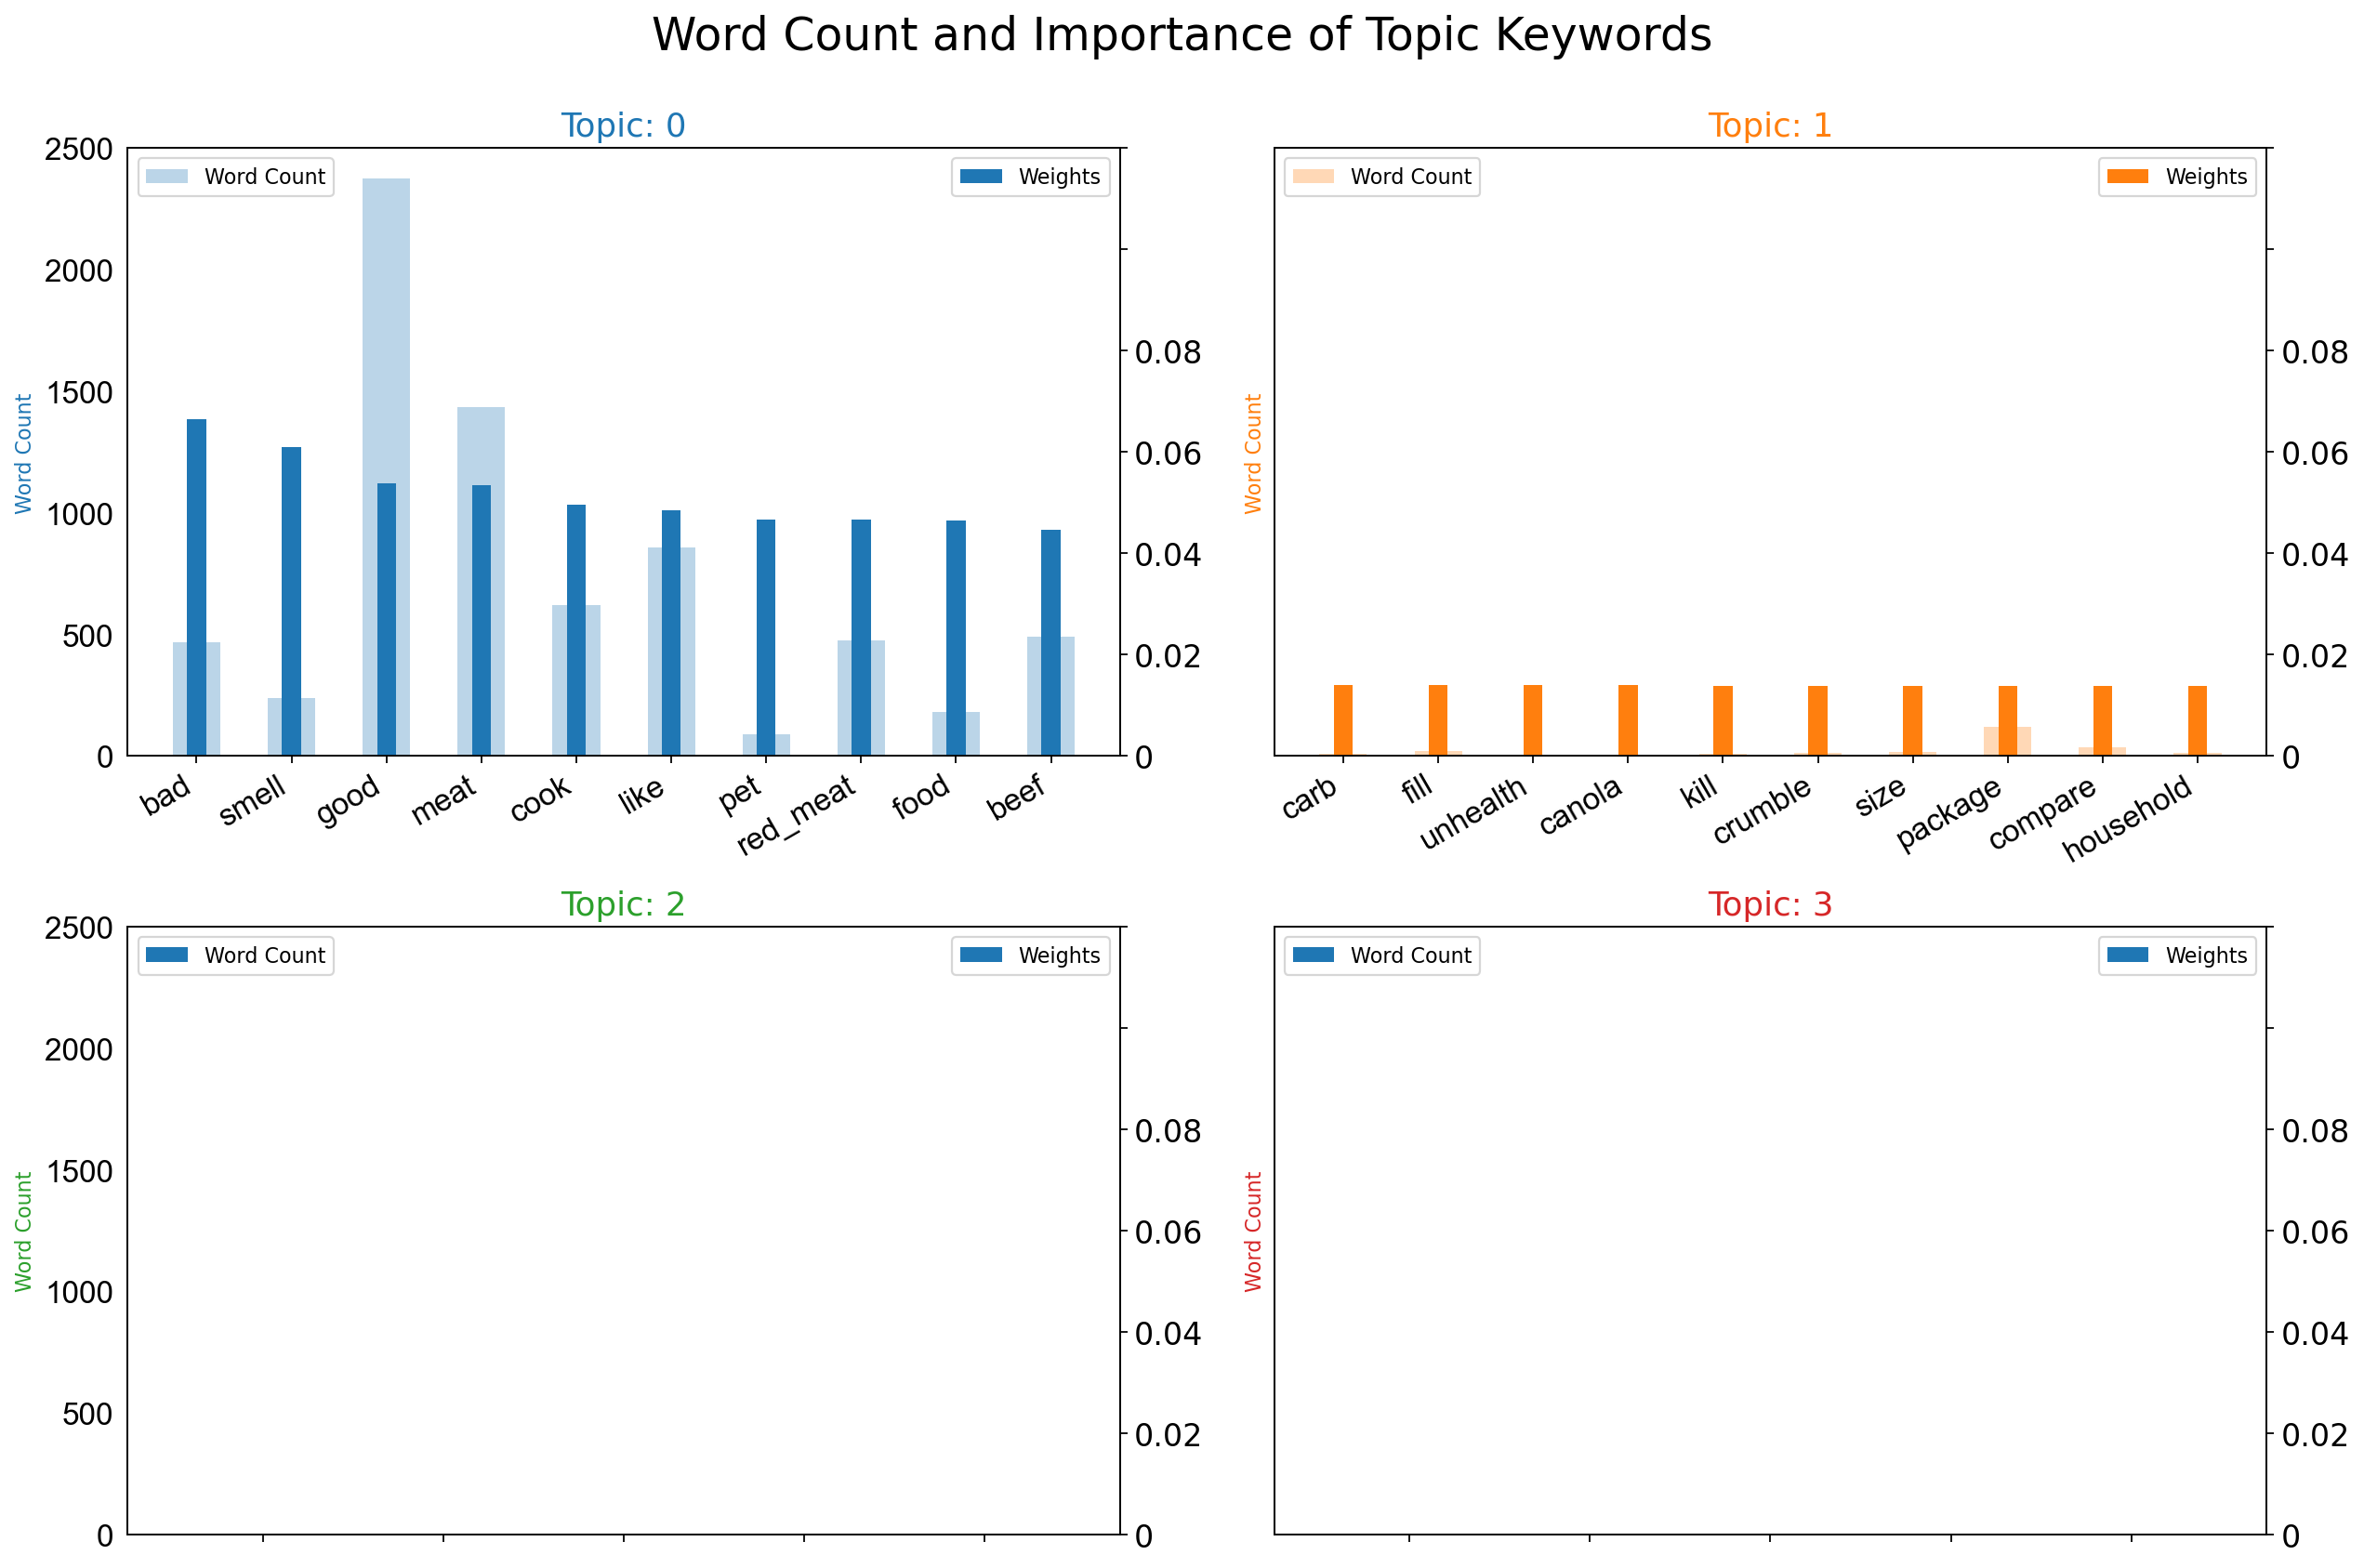

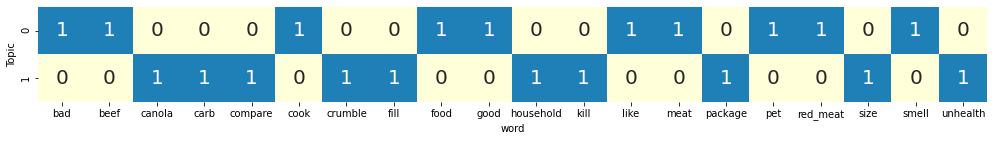

In [116]:
df_topic_sents_keywords = format_topics_sentences(optimal_model_N, doc_term_matrix_N, data_N)


# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
# df_dominant_topic.to_excel("df_TopReviewPerTopic.xlsx")

df_TopReviewPerTopic = getTopReviewsForEachTopic(df_topic_sents_keywords)

df_reviewsInitialText = df_reviews_N[['Text','TextClean', 'TextClean4']]
df_TopReviewPerTopic.merge(df_reviewsInitialText, how='left', on='Text')
df_TopReviewPerTopic.head()

df_TopReviewPerTopic.to_excel("df_TopReviewPerTopic_N.xlsx")

createwordcloud(optimal_model_N, numberOfTopics_N)
df_wordImp = showTopwordsPertopicInGraph(optimal_model_N)
createheatmapofTopwords(gettopicwordsIntoDataframe(optimal_model_N))

In [117]:
df_topic_sents_keywords.Dominant_Topic.value_counts()

0.0    134
Name: Dominant_Topic, dtype: int64

In [118]:
# Group top 5 sentences under each topic
sent_topics_sorted = pd.DataFrame()
df_append_N = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    print(f'i = {i}')
#     print(grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5))
    
    
    df_topic_epitome_reviews = pd.concat([grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)], 
                                            axis=0, ignore_index=True)
    
#     testAppend =  grp.sort_values(['Perc_Contribution'], ascending=[0]).head(5)
    
    df_append_N = df_append_N.append(df_topic_epitome_reviews, ignore_index=True)
 
    #test = df_topic_sents_keywords1.groupby(['Dominant_Topic'], as_index=False)[0].count()
    
#     print(type(df_topic_epitome_reviews))
#     sent_topics_sorted

# Reset Index    
df_append_N.reset_index(drop=True, inplace=True)

# Format
df_append_N.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
df_append_N

i = 0.0


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9433,"bad, smell, good, meat, cook, like, pet, red_meat, food, beef","I bowed to the hype and bought a pack of 2 at Kroger's. As far as looks, these are very close to ground beef in color, both raw and cooked. I opened the package and immediately knew what others me..."
1,0.0,0.9390,"bad, smell, good, meat, cook, like, pet, red_meat, food, beef","This product has a very strange odor to it. The odor reminds me of wet cat food, something I haven't smelled in decades. It is not nearly as strong as an open can of cat food, and it also mostly d..."
2,0.0,0.9373,"bad, smell, good, meat, cook, like, pet, red_meat, food, beef","This is literally the most disgusting vegan burger I have ever eaten - perhaps one of the worst things I have ever eaten, period. I'm not even going to compare this to or mention brands of veg bur..."
3,0.0,0.9361,"bad, smell, good, meat, cook, like, pet, red_meat, food, beef",I bought several packs when they were on sale at Whole Foods with the Prime membership so I got them for about $3 a pack. I was wishing for a great tasting item but when I bit into it I only taste...
4,0.0,0.9339,"bad, smell, good, meat, cook, like, pet, red_meat, food, beef","I haven't been one to ever eat meat, especially the ground beef kind. I grew up vegetarian and when I went to culinary school we went through a beef processing plant and ... yeah, it was nasty. I ..."


In [71]:
# get dataframe of key topics and probs
df_Topic_KeyWords = pd.DataFrame()

for i in range(len(optimal_model_N.show_topics(formatted=False))):
    topic = optimal_model.show_topics(formatted=False)[i][0]
#     print(topic)
    setofKeyWordsAndValues = optimal_model.show_topics(formatted=False)[i][1]
    df = pd.DataFrame(setofKeyWordsAndValues, columns = ["word", "prob"])
    df['topic'] = i
    df_Topic_KeyWords = df_Topic_KeyWords.append(df, ignore_index = True)